<a href="https://colab.research.google.com/github/Jack-Cruz/transfer_learning_exercise/blob/main/Transfer_Learning_in_Images_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning using Inception-v3 for Image Classification**

These notebook was from Dr. Edwyn Javier Aldana, but has been adapted to use fruit datasets.


# **Introduction**

Frequently we face problems that are challenging in terms of memory, storage and computation resources. In order to overcome this situation, we can resort to the use of **Transfer Learning** which consists of taking advantage of the pre-trained  models with large datasets in different application domains.


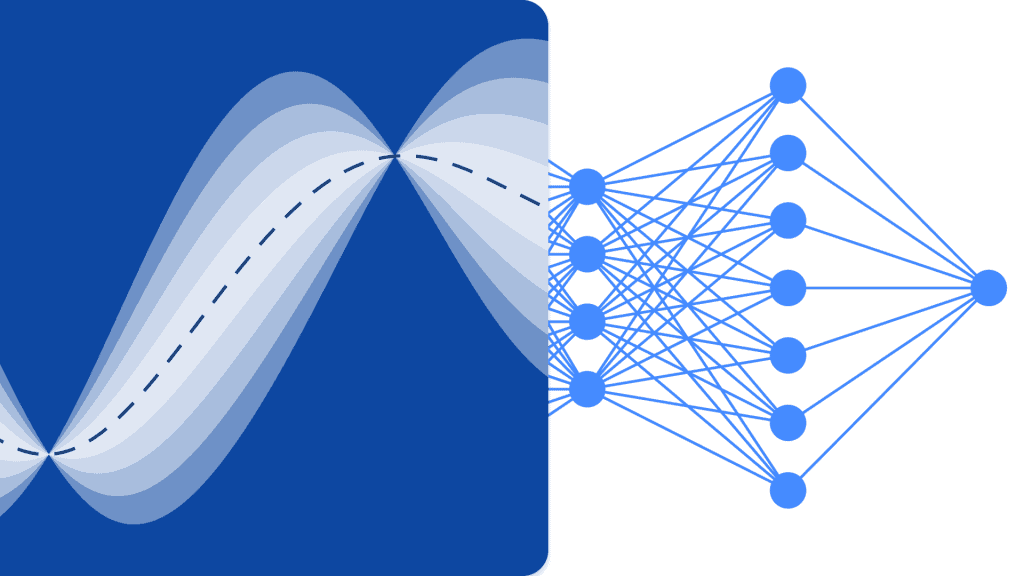

Source:https://www.analyticsinsight.net/transfer-learning-in-deep-learning/

# **Pipeline description**
In order to illustrate the process to create models based on transfer learning, in the following sections, we show this process step by step. 

**Base libraries**

In [1]:
import os
import zipfile # Allows us to zip and unzip files
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

## Getting dataset

**Mount our work directory**

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/MyDrive/UPC ciclo 2022-02/DMC_PEA_data_science/07 Redes Neuronales - Edwin Aldana/data'
%pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/UPC ciclo 2022-02/DMC_PEA_data_science/07 Redes Neuronales - Edwin Aldana/data


'/content/drive/MyDrive/UPC ciclo 2022-02/DMC_PEA_data_science/07 Redes Neuronales - Edwin Aldana/data'

**Unzip dataset**

In [3]:
# Directorys 
base_dir = 'fruits_folders'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training 'apple', 'banana' and 'orange'
train_apple_dir = os.path.join(train_dir, 'apple')
train_banana_dir = os.path.join(train_dir, 'banana')
train_orange_dir = os.path.join(train_dir, 'orange')

# Directory with our validation benign melanoma pictures
validation_apple_dir = os.path.join(validation_dir, 'apple')
validation_banana_dir = os.path.join(validation_dir, 'banana')
validation_orange_dir = os.path.join(validation_dir, 'orange')

**Examples**

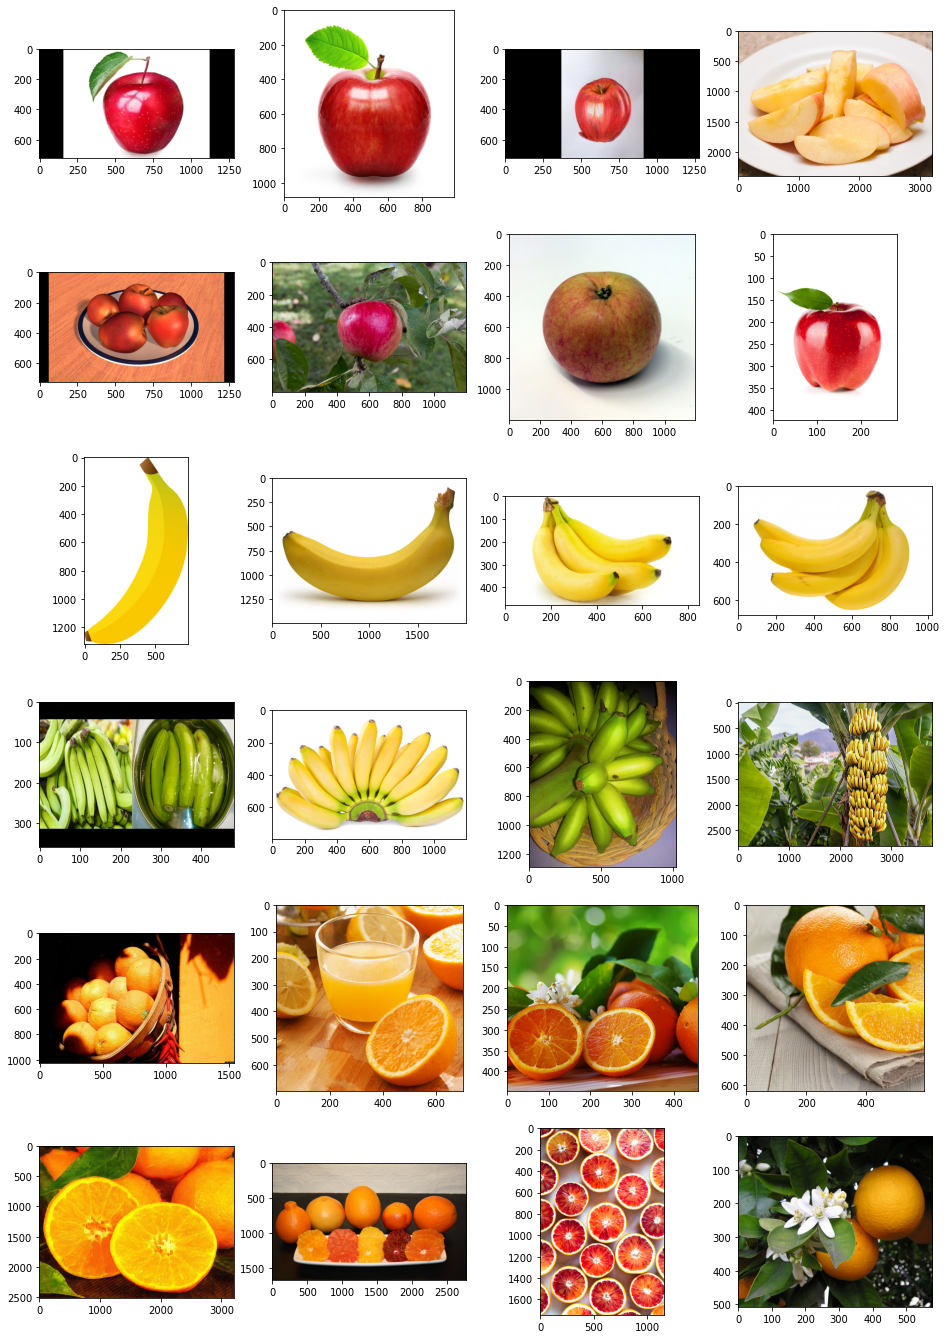

In [5]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 6
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 8
train_apple_fnames = os.listdir(train_apple_dir)
train_banana_fnames = os.listdir(train_banana_dir)
train_orange_fnames = os.listdir(train_orange_dir)


next_apple_pix = [os.path.join(train_apple_dir, fname) 
                for fname in train_apple_fnames[pic_index-8:pic_index] 
               ]

next_banana_pix = [os.path.join(train_banana_dir, fname) 
                for fname in train_banana_fnames[pic_index-8:pic_index]
               ]

next_orange_pix = [os.path.join(train_orange_dir, fname) 
                for fname in train_orange_fnames[pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_apple_pix + next_banana_pix + next_orange_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**Getting the pre-trained model**

In [ ]:
# !wget -q \
    # https://www.dropbox.com/s/1dgux9udiby9zev/Inception_V3.zip


In [ ]:
# !unzip 'Inception_V3'

Archive:  Inception_V3.zip
replace inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Learning Process

**Preparing the dataset**

In what follows, we show the setting of the dataset to carry out the learning.

Notice that in order to improve the learning process, we have included sevarl option that allows us to increase the cardinality of our training dataset (**aumented dataset**) by means of sligth modifications.

```
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, #rotation grade
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, #distortion along an axis 
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
```




In [6]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, #previously defined
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,  #previously defined
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 212 images belonging to 3 classes.
Found 28 images belonging to 3 classes.


**Import the Inception model**

In what follows, we are going to load the pre-trained model that has been trained with a large set of images.

In [7]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [8]:
size_images=(150,150,3)
pre_trained_model = InceptionV3(input_shape = size_images, # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [9]:
pre_trained_model

It is necessary to indicate that all layers of pre-trained model will not included in the learning process of our model

In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False

**Design our trainable neural network**



1.   We use the output of the pre-trained model as input of our model.
2.   We define a hidden layer with 16 neurons that include Relu as activation function
3. Finally, we add an output neuron that define the last layer for classification.






In [12]:
x = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(16, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

Additionally, it is necessary to define the **loss function** and the optimization algorithm for the process of **backpropagation** of our network. In this regard, we use:


1.   **Cross entropy** as loss function
2.   **Adam** as optimizer with a learning ratio of 0.0001





In [14]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics = ['acc'])

**Flow images in batches of 20 using train _datagen and test_datagen**

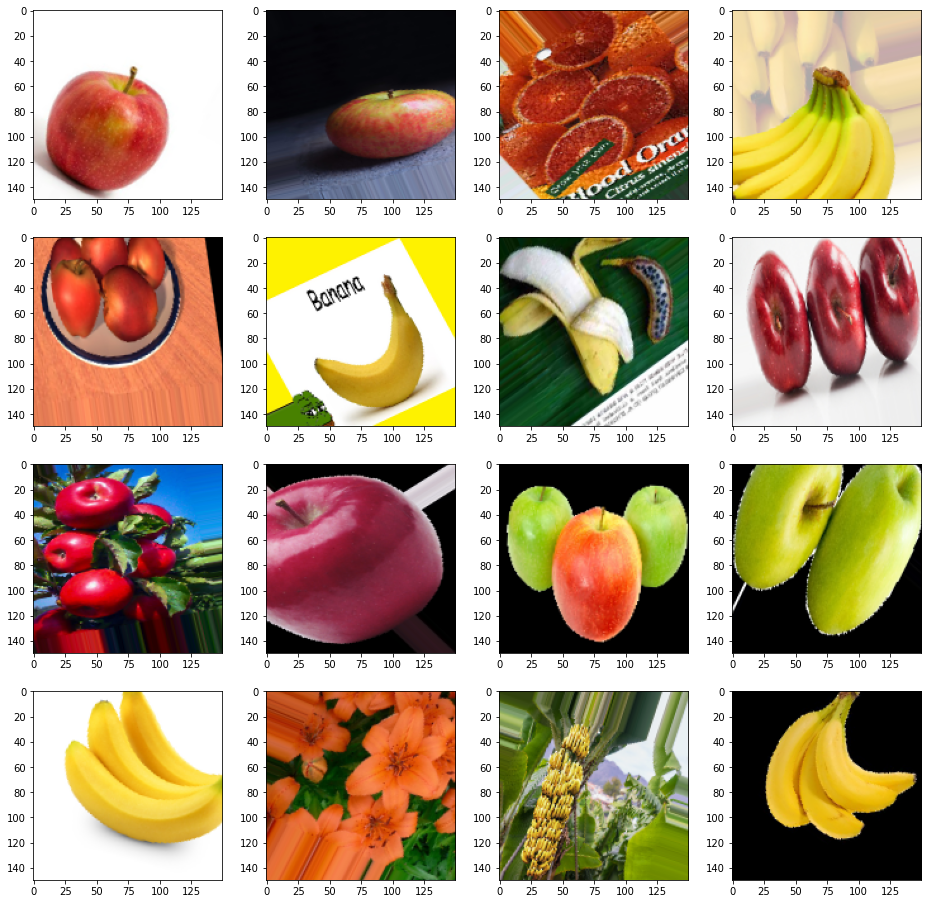

In [15]:
# Get a batch of augmented images from train_generator
augmented_images, _ = train_generator.next()

# Plot some augmented images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i])

plt.show()


**We start the training**

In [16]:
#callbacks = myCallback()
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size #212/16=13.25
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size #28/20=1.4

history=model.fit(  train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5
)


Epoch 1/5
6/6 [==============================] - 66s 11s/step - loss: 1.7747 - acc: 0.4278 - val_loss: 0.7005 - val_acc: 0.7500
Epoch 2/5
6/6 [==============================] - 26s 4s/step - loss: 0.8890 - acc: 0.5722 - val_loss: 0.5233 - val_acc: 0.8500
Epoch 3/5
6/6 [==============================] - 27s 4s/step - loss: 0.7352 - acc: 0.6198 - val_loss: 0.3679 - val_acc: 0.8000
Epoch 4/5
6/6 [==============================] - 31s 5s/step - loss: 0.6317 - acc: 0.6889 - val_loss: 0.2068 - val_acc: 0.9000
Epoch 5/5
6/6 [==============================] - 24s 4s/step - loss: 0.5524 - acc: 0.7292 - val_loss: 0.2429 - val_acc: 0.9000


**Plot Accuracy and Loss**

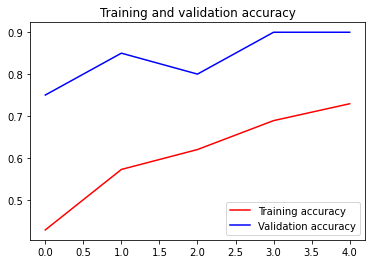

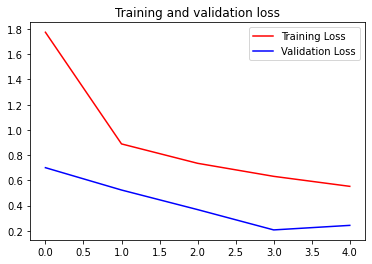

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Save model

In [19]:
# Guardar modelo
model.save('dmc_fruits_modelo_Adam_5_epochs.h5')

## Testing Process

In [20]:
from keras.models import load_model
model = load_model('dmc_fruits_modelo_Adam_5_epochs.h5')

**Test with custom images**

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
import glob

# Especificando el directorio que contiene las imágenes
img_dir = 'fruits_folders/test/orange/'
img_paths = glob.glob(img_dir + '*.jpg')

for path in img_paths:
    
    # Cargando la imagen en el tamaño requerido para el modelo
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255

    prediction = model.predict(x, batch_size=10)
    print(prediction)
    print(np.argmax(prediction))


1/1 [==============================] - 0s 154ms/step
[[0.00562235 0.00261028 0.99176735]]
2
1/1 [==============================] - 0s 144ms/step
[[7.7981193e-04 6.4668752e-04 9.9857354e-01]]
2
1/1 [==============================] - 0s 149ms/step
[[0.11711956 0.15255755 0.7303229 ]]
2
1/1 [==============================] - 0s 155ms/step
[[0.00374858 0.00295692 0.9932944 ]]
2
1/1 [==============================] - 0s 131ms/step
[[0.02558203 0.00393835 0.97047955]]
2
1/1 [==============================] - 0s 148ms/step
[[0.00478097 0.00334469 0.9918744 ]]
2
1/1 [==============================] - 0s 152ms/step
[[0.04165503 0.01077938 0.9475656 ]]
2
1/1 [==============================] - 0s 137ms/step
[[8.5559033e-04 4.6641397e-04 9.9867803e-01]]
2
1/1 [==============================] - 0s 139ms/step
[[0.00478097 0.00334469 0.9918744 ]]
2
